# Hand Tracking Model
## Bartosz Dańko, 325459
**Hand Tracking Model** is a model that is able to recognize gestures based on the landmarks of the hand.

The model is trained on the dataset of landmarks extracted from the images of the hand. The landmarks are extracted using the [MediaPipe library](https://developers.google.com/mediapipe).
The program is based on [Kinivi hand gesture recognition model](https://github.com/kinivi/hand-gesture-recognition-mediapipe)

## Load imports

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import mediapipe as mp
import os
import cv2
from hand_tracking import extract_landmarks, normalization
RANDOM_SEED = 41

pygame 2.5.2 (SDL 2.28.3, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Load file paths

In [2]:
dataset = 'landmark_data/landmarks_data.csv'

dataset_open = 'landmark_data/gesture_open'
dataset_close = 'landmark_data/gesture_close'
dataset_pointer = 'landmark_data/gesture_pointer'

model_save_path = 'model_save/hand_tracking_model.keras'
model_non_save_path = 'model_save/hand_tracking_model_non.keras'
model_cnn_save_path = 'model_save/hand_tracking_model_cnn.keras'
model_lstm_save_path = 'model_save/hand_tracking_model_lstm.keras'
model_gru_save_path = 'model_save/hand_tracking_model_gru.keras'

hdf5_save_path = 'model_save/hand_tracking_model.hdf5'

tflite_save_path = 'model_save/hand_tracking_model.tflite'

## Number of classes

In [3]:
NUM_CLASSES = 3

For now, the model recognizes 3 gestures:
* **OPEN** - open hand gesture
* **CLOSE** - closed hand gesture
* **POINTER** - pointing hand gesture

## Dataset reading
Load:
* X_dataset - coordinates of landmarks
* Y_dataset_str - labels of gesture with string labels

### Text dataset (only if needed)
This part of code is not used. It is only for the case when the dataset in the image format is not available and the dataset is in the text.

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)), skiprows=1)

In [5]:
Y_dataset_str = np.loadtxt(dataset, delimiter=',', dtype='str', usecols=(0), skiprows=1)

### Divide photo registration and point extraction

#### Extract function
**extract_landmarks_second(image, hand)** is a function that extracts landmarks from the image using the MediaPipe library. The function returns a 42-element array of landmarks

<code>extract_landmarks_second(image, hand)</code>

**Parameters:**
* image - preferred image size is 640x360px (but it can be different)
* hand - MediaPipe Hands object

**Returns:**
* landmarks - 42-element array of landmarks
    * The function accept only (42,) array of landmarks
        * If it is less than 42, it will be padded with zeros
        * If it is more than 42, it will be cut to 42   

In [6]:
def extract_landmarks_second(image, hand):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    result = hand.process(image_rgb)

    landmarks = []

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            for lm in hand_landmarks.landmark:
                h, w, _ = image.shape
                cx, cy = int(lm.x * w), int(lm.y * h)
                landmarks.extend([cx, cy])
    landmarks = np.array(landmarks)
    if len(landmarks) < 42:
        landmarks = np.pad(landmarks, (0, 42 - len(landmarks)), 'constant')
    elif len(landmarks) > 42:
        landmarks = landmarks[:42]
    return landmarks

#### Extract landmarks
This part of code is used to extract landmarks from the images in the dataset. Images are divided into **3 folders**. Each folder contains images of a different gesture. Every loop extracts landmarks from the image and adds them to the dataset. After this part of code we have two lists with **landmarks** and **labels**.


In [7]:
landmarks = []
labels = []
images = []
image_names = []

mp_hands = mp.solutions.hands
hand = mp_hands.Hands()
for image in os.listdir(dataset_open):
    image_path = os.path.join(dataset_open, image)
    img = cv2.imread(image_path)
    images.append(img)
    image_names.append(os.path.basename(image_path))
    landmark = extract_landmarks_second(img, hand)
    landmarks.append(landmark.tolist())
    labels.append("OPEN")
        
for image in os.listdir(dataset_close):
    image_path = os.path.join(dataset_close, image)
    img = cv2.imread(image_path)
    images.append(img)
    image_names.append(os.path.basename(image_path))
    landmark = extract_landmarks_second(img, hand)
    landmarks.append(landmark.tolist())
    labels.append("CLOSE")
    
for image in os.listdir(dataset_pointer):
    image_path = os.path.join(dataset_pointer, image)
    img = cv2.imread(image_path)
    images.append(img)
    image_names.append(os.path.basename(image_path))
    landmark = extract_landmarks_second(img, hand)
    landmarks.append(landmark.tolist())
    labels.append("POINTER")

**Copy to the dataset**
To copy the dataset to the X_dataset and Y_dataset_str variables, we need to convert the list to the [numpy array](https://numpy.org/doc/stable/reference/generated/numpy.array.html).

In [8]:
X_dataset = np.array(landmarks)
Y_dataset_str = np.array(labels)

Checking some samples:

In [9]:
print("First 5 rows of dataset X:")
print(X_dataset[:5])

print("First 5 rows of dataset Y:")
print(Y_dataset_str[:5])

First 5 rows of dataset X:
[[632. 509. 670. 488. 699. 454. 724. 418. 755. 393. 684. 373. 695. 321.
  694. 285. 693. 255. 656. 368. 659. 311. 656. 273. 653. 239. 629. 375.
  624. 323. 618. 290. 614. 261. 603. 393. 581. 356. 566. 331. 555. 306.]
 [634. 511. 669. 488. 698. 452. 723. 417. 753. 394. 684. 371. 694. 319.
  695. 283. 694. 252. 656. 366. 659. 309. 654. 272. 649. 240. 630. 374.
  624. 324. 618. 290. 613. 262. 602. 392. 581. 357. 567. 332. 557. 307.]
 [672. 521. 718. 488. 746. 437. 767. 398. 795. 374. 692. 371. 695. 319.
  697. 285. 697. 255. 658. 372. 650. 315. 645. 278. 640. 246. 628. 386.
  612. 334. 604. 301. 599. 271. 602. 412. 577. 376. 562. 352. 552. 327.]
 [567. 384. 630. 344. 671. 282. 701. 227. 729. 187. 613. 206. 626. 135.
  630.  90. 630.  49. 568. 202. 565. 124. 561.  73. 555.  29. 526. 216.
  514. 141. 508.  93. 502.  52. 487. 242. 455. 186. 434. 147. 417. 109.]
 [550. 393. 609. 352. 651. 285. 681. 229. 712. 188. 593. 207. 605. 136.
  608.  89. 607.  46. 548. 204. 5

In [10]:
# Check unique values of Y dataset
print("Label set unique values: ", list(np.unique(Y_dataset_str)))

Label set unique values:  ['CLOSE', 'OPEN', 'POINTER']


### Label encoding
The **Y dataset** is a string dataset. To use it in the model, we need to encode it to the integer dataset. We can use the [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) from the sklearn library.

In [11]:
# Set label encoder to the Y dataset
label_encoder = LabelEncoder()
Y_dataset = label_encoder.fit_transform(Y_dataset_str)

print("Label set unique values: ", list(np.unique(Y_dataset)))

Label set unique values:  [0, 1, 2]


# Preparation
To find the best solutions I use 5 different options:
1. **Model #1** with normalization
2. **Model #1** without normalization
3. **Model #2 (CNN)** with normalization
4. **Model #3 (LSTM)** with normalization
5. **Model #4 (GRU)** with normalization

## Data normalization
To improve the model's performance, we need to normalize the dataset.

The dataset is normalized to the mean value of the x and y coordinates of the landmarks. The normalization is done by subtracting the mean value from the x and y coordinates of the landmarks.
Normalization have two steps:
1. Calculate the mean value of the x and y coordinates of the landmarks
2. Subtract the mean value from the x and y coordinates of the landmarks

In [12]:
def normalization(dataset):
    mean_x = np.mean(dataset[:, ::2], axis=1)
    mean_y = np.mean(dataset[:, 1::2], axis=1)
    
    normalized_dataset = np.zeros_like(dataset)
    
    for i in range(dataset.shape[0]):
        normalized_dataset[i, ::2] = dataset[i, ::2] - mean_x[i]
        normalized_dataset[i, 1::2] = dataset[i, 1::2] - mean_y[i]
    return normalized_dataset

In [13]:
# Dataset with normalization
normalized_X_dataset = normalization(X_dataset)
X_train, X_test, Y_train, Y_test = train_test_split(normalized_X_dataset, Y_dataset, test_size=0.75, random_state=RANDOM_SEED)

# Dataset without normalization
X_train_non, X_test_non, Y_train_non, Y_test_non = train_test_split(X_dataset, Y_dataset, test_size=0.75, random_state=RANDOM_SEED)

## Model #1

The **Model #1** is a simple neural network with 3 hidden layers.
It is a sequential model with the following layers:
1. **Input layer** - 42 neurons
2. **Dropout layer** - it is used to prevent overfitting by randomly setting a fraction rate of input units to 0 at each update during training time.
3. **Dense layer with the ReLU activation function** - it is a fully connected layer with 21 neurons and the ReLU activation function - it is used to introduce non-linearity to the model.
4. **Dense layer with the softmax activation function** - it is a fully connected layer with 3 neurons and the softmax activation function - it is used to classify the input data into a specific class.

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.15),

    tf.keras.layers.Dense(21, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
model_non = tf.keras.models.clone_model(model)

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 21)             │           903 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            44 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,182 (4.62 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
checkpoints_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=0, save_weights_only=False)
checkpoints_callback_non = tf.keras.callbacks.ModelCheckpoint(model_non_save_path, verbose=0, save_weights_only=False)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=0)

**Checkpoints Callback** - it is used to save the best model during the training process.
**Early Stopping Callback** - it is used to stop the training process if the model does not improve after a certain number of epochs.

In [17]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model_non.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

**Compile parameters:**
* **optimizer** - it is used to optimize the model. The Adam optimizer is used in this case because 

# Model training

In [18]:
model.fit(
    X_train,
    Y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, Y_test),
    callbacks=[checkpoints_callback, early_stopping_callback],
    verbose=0
)
model_non.fit(
    X_train_non,
    Y_train_non,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test_non, Y_test_non),
    callbacks=[checkpoints_callback_non, early_stopping_callback],
    verbose=0
)

In [19]:
val_loss, val_acc = model.evaluate(X_test, Y_test, batch_size=128)
val_loss_non, val_acc_non = model.evaluate(X_test_non, Y_test_non, batch_size=128)

print(f"Normalization: Validation loss: {val_loss}, Validation accuracy: {val_acc}")
print(f"Without normalization: Validation loss: {val_loss_non}, Validation accuracy: {val_acc_non}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9796 - loss: 0.0696 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3795 - loss: 30.0768 
Normalization: Validation loss: 0.052161652594804764, Validation accuracy: 0.9859265089035034
Without normalization: Validation loss: 29.661441802978516, Validation accuracy: 0.3784206509590149


In [20]:
model = tf.keras.models.load_model(model_save_path)
model_non = tf.keras.models.load_model(model_non_save_path)

predict_result = model.predict(np.array([X_test[0]]))
predict_result_non = model_non.predict(np.array([X_test_non[0]]))

print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

print(np.squeeze(predict_result_non))
print(np.argmax(np.squeeze(predict_result_non)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
[9.9998927e-01 0.0000000e+00 1.0719087e-05]
0
[0.00081425 0.7987356  0.20045017]
1


## Confusion matrix

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


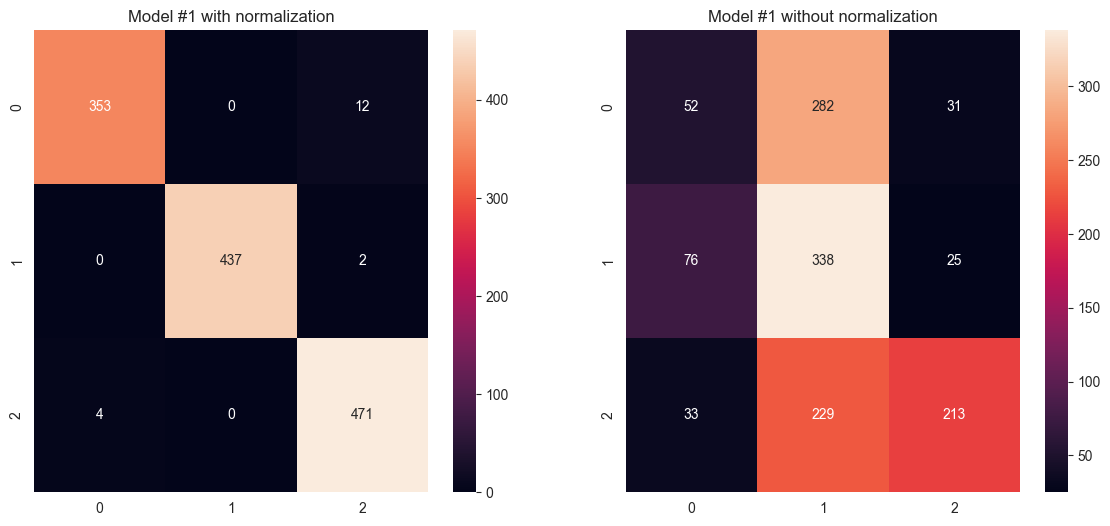

Raport klasyfikacji dla modelu 1
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       365
           1       1.00      1.00      1.00       439
           2       0.97      0.99      0.98       475

    accuracy                           0.99      1279
   macro avg       0.99      0.98      0.99      1279
weighted avg       0.99      0.99      0.99      1279

Raport klasyfikacji dla modelu 2
              precision    recall  f1-score   support

           0       0.32      0.14      0.20       365
           1       0.40      0.77      0.52       439
           2       0.79      0.45      0.57       475

    accuracy                           0.47      1279
   macro avg       0.50      0.45      0.43      1279
weighted avg       0.52      0.47      0.45      1279



In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true1, y_pred1, y_true2, y_pred2, model1, model2, report=True):
    labels1 = sorted(list(set(y_true1)))
    labels2 = sorted(list(set(y_true2)))
    cmx_data1 = confusion_matrix(y_true1, y_pred1, labels=labels1)
    cmx_data2 = confusion_matrix(y_true2, y_pred2, labels=labels2)

    df_cmx1 = pd.DataFrame(cmx_data1, index=labels1, columns=labels1)
    df_cmx2 = pd.DataFrame(cmx_data2, index=labels2, columns=labels2)

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # Zmienione na 1 wiersz i 2 kolumny

    sns.heatmap(df_cmx1, annot=True, fmt='g' ,square=False, ax=axs[0])
    axs[0].set_ylim(len(set(y_true1)), 0)
    axs[0].set_title(f'Model {model1}')

    sns.heatmap(df_cmx2, annot=True, fmt='g' ,square=False, ax=axs[1])
    axs[1].set_ylim(len(set(y_true2)), 0)
    axs[1].set_title(f'Model {model2}')

    plt.show()

    if report:
        print('Raport klasyfikacji dla modelu 1')
        print(classification_report(y_true1, y_pred1))
        print('Raport klasyfikacji dla modelu 2')
        print(classification_report(y_true2, y_pred2))

# Wydrukuj macierze pomyłek

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

Y_pred_non = model_non.predict(X_test_non)
y_pred_non = np.argmax(Y_pred_non, axis=1)

print_confusion_matrix(Y_test, y_pred, Y_test_non, y_pred_non, "#1 with normalization", "#1 without normalization")

## Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


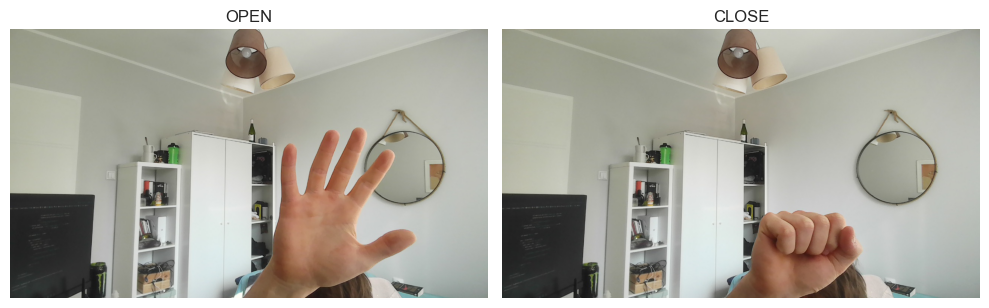

In [22]:
import mediapipe as mp
import cv2
import matplotlib.pyplot as plt
import random
import os
from hand_tracking import extract_landmarks
model_to_test = tf.keras.models.load_model('model_save/hand_tracking_model.keras')



open_folder = 'landmark_data/gesture_open'
close_folder = 'landmark_data/gesture_close'


def normalization(landmarks):
    landmarks = np.reshape(landmarks, (1, -1))  # Zamienia tablicę 1x42 na 21x2
    mean_x = np.mean(landmarks[:, ::2], dtype=float)  # Średnia dla pierwszej kolumny
    mean_y = np.mean(landmarks[:, 1::2], dtype=float)  # Średnia dla drugiej kolumny
    
    normalized_landmarks = np.zeros_like(landmarks, dtype=float)
    
    normalized_landmarks[:, ::2] = landmarks[:, ::2] - mean_x
    normalized_landmarks[:, 1::2] = landmarks[:, 1::2] - mean_y
    
    return np.reshape(normalized_landmarks, (1, -1))
    
def predict(image):
    mp_hands = mp.solutions.hands
    hand = mp_hands.Hands()
    
    landmarks = extract_landmarks(image, hand)
    landmarks = normalization(landmarks)
    
    prediction = model.predict(landmarks)
    hand_state = np.argmax(prediction)
    if hand_state == 0:
        return "CLOSE", image
    else:
        return "OPEN", image

def prepare_test(rows):
    images = []
    titles = []
    for _ in range(rows):
        image_index = random.randint(0, len(os.listdir(open_folder))-150)
        image = cv2.imread(os.path.join(open_folder, f"o_{image_index}.jpg"))
        images.append(image)
        titles.append(predict(image)[0])
    for _ in range(rows):
        image_index = random.randint(0, len(os.listdir(close_folder))-150)
        image = cv2.imread(os.path.join(close_folder, f"c_{image_index}.jpg"))
        images.append(image)
        titles.append(predict(image)[0])
    return images, titles

def display_test(rows):
    fig, axs = plt.subplots(rows, 2, figsize=(10, 8))
    images, titles = prepare_test(rows)
    
    for i, ax in enumerate(axs.flat):
        ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
display_test(1)

# Model #2 (CNN)

The **Model #2** is a convolutional neural network with 3 convolutional layers and 2 dense layers. It is a model with the following layers:
1. **Input layer** - 42 neurons
2. **Reshape layer** - it is used to reshape the input data to the 21x2 shape
3. **Convolutional layers with the ReLU activation function** - it is a convolutional layers with 32, 64 and 128 filters and the ReLU activation function
4. **Max pooling layer** - it is used to reduce the spatial dimensions of the output volume
5. **Flatten layer** - it is used to flatten the input data
6. **Dense layer with the ReLU activation function** - it is a fully connected layer with 128 neurons and the ReLU activation function
7. **Dense layer with the softmax activation function** - it is a fully connected layer with 3 neurons and the softmax activation function

In [23]:
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Reshape((21, 2, 1)),
    
    tf.keras.layers.Conv2D(32, (2, 2), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((1, 1)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (4, 4), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((1, 1)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 21)             │           903 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            44 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,548 (13.86 KB)

 Trainable params: 1,182 (4.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,366 (9.25 KB)

In [25]:
checkpoints_callback = tf.keras.callbacks.ModelCheckpoint(model_cnn_save_path, verbose=0, save_weights_only=False)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=0)

In [26]:
model_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
model_cnn.fit(
    X_train,
    Y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, Y_test),
    callbacks=[checkpoints_callback, early_stopping_callback],
    verbose=0
)

In [28]:
val_loss, val_acc = model_cnn.evaluate(X_test, Y_test, batch_size=128)

print(f"Normalization: Validation loss: {val_loss}, Validation accuracy: {val_acc}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9796 - loss: 0.0873
Normalization: Validation loss: 0.06785795092582703, Validation accuracy: 0.9859265089035034


In [29]:
model_cnn = tf.keras.models.load_model(model_cnn_save_path)

# Model #3 (LSTM)
The **Model #3** is a Long Short-Term Memory network with 3 LSTM layers and 2 dense layers. It is a model with the following layers:
1. **Input layer** - 42 neurons
2. **Reshape layer** - it is used to reshape the input data to the 21x2 shape
3. **LSTM layers** - it is a LSTM layers with 32, 64 and 128 units
4. **Dense layer** - it is a fully connected layer with 128 neurons and the ReLU activation function
5. **Dense layer with the softmax activation function** - it is a fully connected layer with 3 neurons and the softmax activation function


In [30]:
model_lstm = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Reshape((21, 2)),
    
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(128),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])  

In [31]:
model_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 21, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 21, 32)         │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 21, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 145,027 (566.51 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
checkpoints_callback = tf.keras.callbacks.ModelCheckpoint(model_lstm_save_path, verbose=0, save_weights_only=False)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=0)

In [33]:
model_lstm.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [34]:
model_lstm.fit(
    X_train,
    Y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, Y_test),
    callbacks=[checkpoints_callback, early_stopping_callback],
    verbose=0
)

In [35]:
val_loss, val_acc = model_lstm.evaluate(X_test, Y_test, batch_size=128)

print(f"Normalization: Validation loss: {val_loss}, Validation accuracy: {val_acc}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9785 - loss: 0.1064
Normalization: Validation loss: 0.0964793711900711, Validation accuracy: 0.9812353253364563


In [36]:
model_lstm = tf.keras.models.load_model(model_lstm_save_path)

# Model #4 (GRU)
The **Model #4** is a Gated Recurrent Unit network with 3 GRU layers and 2 dense layers. It is a model with the following layers:
1. **Input layer** - 42 neurons
2. **Reshape layer** - it is used to reshape the input data to the 21x2 shape
3. **GRU layers** - it is a GRU layers with 32, 64 and 128 units
4. **Dense layer** - it is a fully connected layer with 128 neurons and the ReLU activation function
5. **Dense layer with the softmax activation function** - it is a fully connected layer with 3 neurons and the softmax activation function

In [37]:
model_gru = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Reshape((21, 2)),
    
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(128),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [38]:
checkpoints_callback = tf.keras.callbacks.ModelCheckpoint(model_gru_save_path, verbose=0, save_weights_only=False)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=0)

In [39]:
model_gru.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [40]:
model_gru.fit(
    X_train,
    Y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, Y_test),
    callbacks=[checkpoints_callback, early_stopping_callback],
    verbose=0
)

In [41]:
val_loss, val_acc = model_gru.evaluate(X_test, Y_test, batch_size=128)

print(f"Normalization: Validation loss: {val_loss}, Validation accuracy: {val_acc}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9758 - loss: 0.1001
Normalization: Validation loss: 0.08124686777591705, Validation accuracy: 0.9788897633552551


# Summary

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━

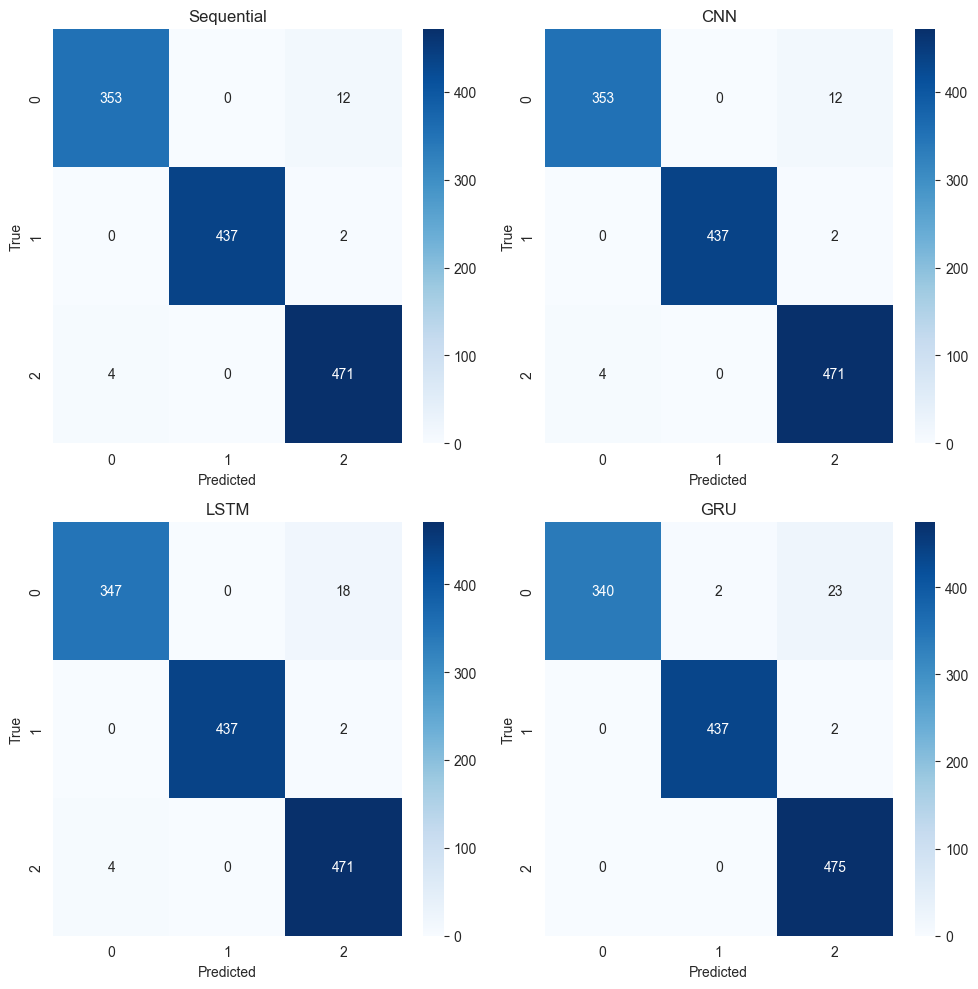

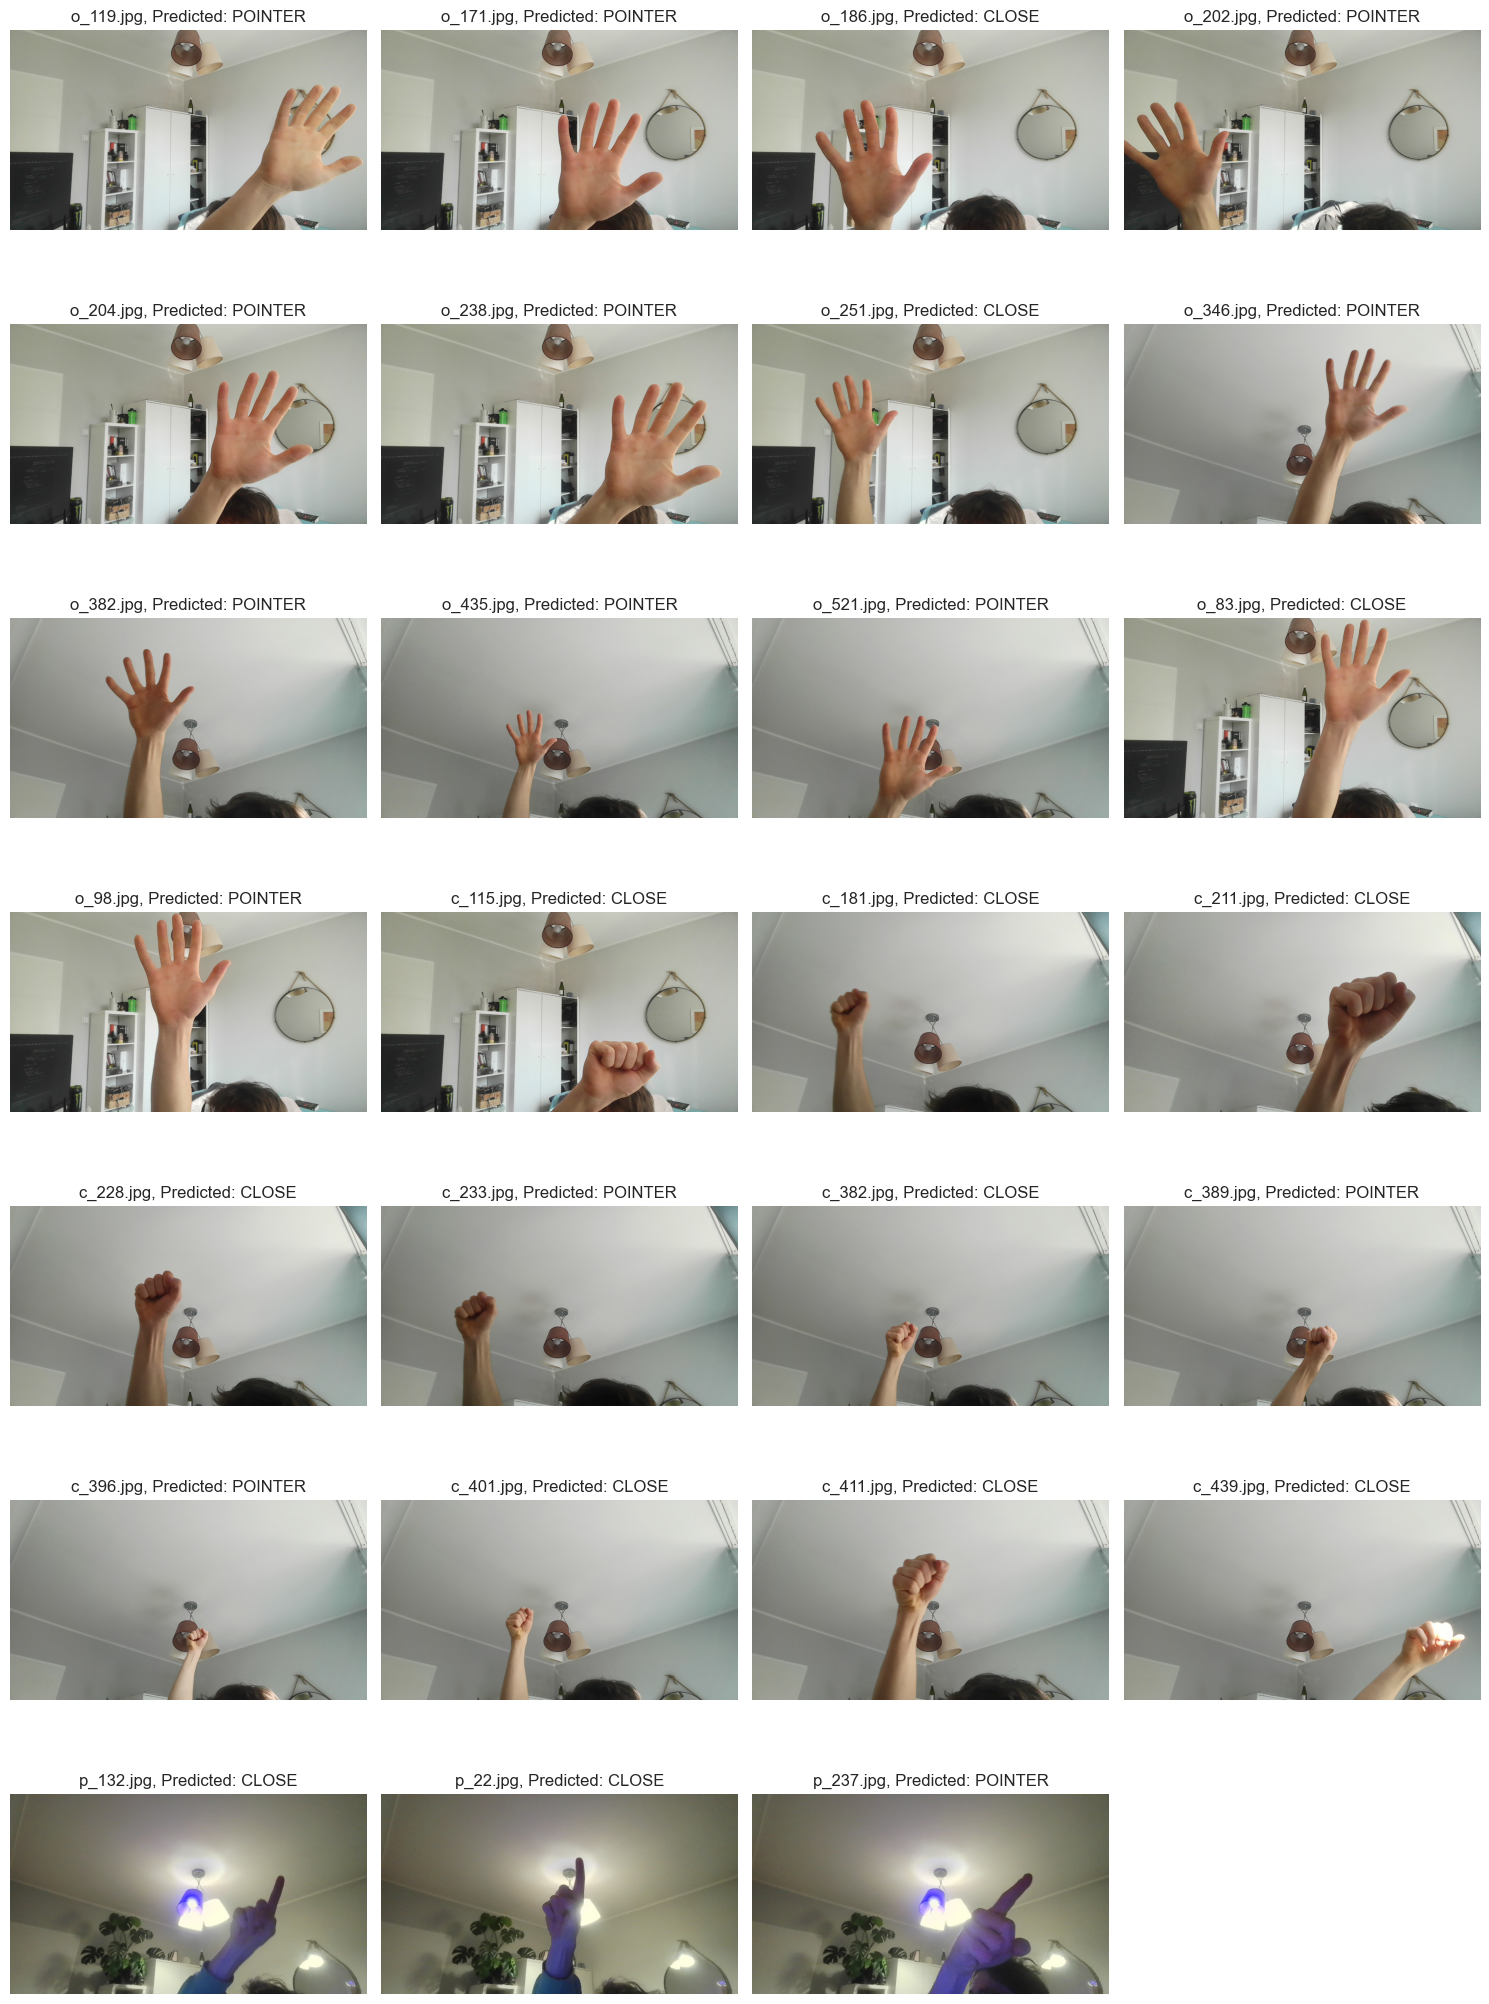

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Załaduj modele
model_seq = tf.keras.models.load_model('model_save/hand_tracking_model.keras')
model_cnn = tf.keras.models.load_model('model_save/hand_tracking_model_cnn.keras')
model_lstm = tf.keras.models.load_model('model_save/hand_tracking_model_lstm.keras')
model_gru = tf.keras.models.load_model('model_save/hand_tracking_model_gru.keras')

# Lista modeli
models = [model_seq, model_cnn, model_lstm, model_gru]
model_names = ['Sequential', 'CNN', 'LSTM', 'GRU']

# Lista niepoprawnych przewidywań
incorrects = []
wrong_predicts = []

# Tworzenie wykresów
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    # Przewidywanie
    Y_pred = models[i].predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    incorrects = np.nonzero(y_pred != Y_test)
    
    # Tworzenie macierzy pomyłek
    cm = confusion_matrix(Y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(model_names[i])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()

import math

# Obliczanie liczby wierszy na podstawie liczby niepoprawnych predykcji i liczby kolumn
rows = math.ceil(len(incorrects[0]) / 4)

# Tworzenie siatki wykresów
fig, axs = plt.subplots(rows, 4, figsize=(15, rows*3))

# Spłaszczenie osi, aby łatwiej było iterować
axs = axs.flatten()

# Przejście przez wszystkie indeksy w incorrects
for i, incorrect in enumerate(incorrects[0]):
    # Wyświetlenie zdjęcia
    axs[i].imshow(cv2.cvtColor(images[incorrect], cv2.COLOR_BGR2RGB))
    # Przewidywanie etykiety dla zdjęcia
    predicted_label = model.predict(np.array([X_test[incorrect]]))
    predicted_label = np.argmax(predicted_label)
    predicted_label = label_encoder.inverse_transform([predicted_label])[0]
    axs[i].set_title(f"{image_names[incorrect]}, Predicted: {predicted_label}")
    axs[i].axis('off')

# Usunięcie pustych wykresów
for i in range(len(incorrects[0]), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

We can see some examples of incorrect predictions. The model has some problems with the **CLOSE** gesture. The **OPEN** and **POINTER** gestures are predicted correctly. It can be caused by the similarity of the **CLOSE** gesture to the **POINTER** gesture.

All four models have a similar accuracy. The best model is the **Sequential model** with normalization. The **CNN model** has the worst accuracy.